# V928 Tau - Stellar Variation

In this notebook we model the stellar variations of V928 Tau system. We start off with the corrected light curve from the <strong>everest 2.0</strong> pipeline and determine the model for the stellar variations ignoring the eclipse. To do this we note here that V928 Tau is a long-period binary, which has been blended together in a single <strong>K2</strong> pixel. We see a very clear beating pattern, which we assume to be rotational modulation induced by star spots with similar rotational periods. Below follows the analysis to clean up the light curve.

In [1]:
import emcee
import logging
import everest
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from Code import stellar_variation as sv
from Code import mcmc

%matplotlib inline
logging.getLogger('matplotlib.font_manager').disabled = True

## Extracting the Light Curve

We extract and normalise the light curve from the <strong>everest 2.0</strong> pipeline.

INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 247795097.
INFO  [everest.user.plot()]: Plotting the light curve...


/Users/dmvandam/anaconda3/lib/python3.7/site-packages/everest/user.py:791: RuntimeWarning: invalid value encountered in less
  for i in np.where(flux < ylim[0])[0]:
/Users/dmvandam/anaconda3/lib/python3.7/site-packages/everest/user.py:807: RuntimeWarning: invalid value encountered in greater
  for i in np.where(flux > ylim[1])[0]:


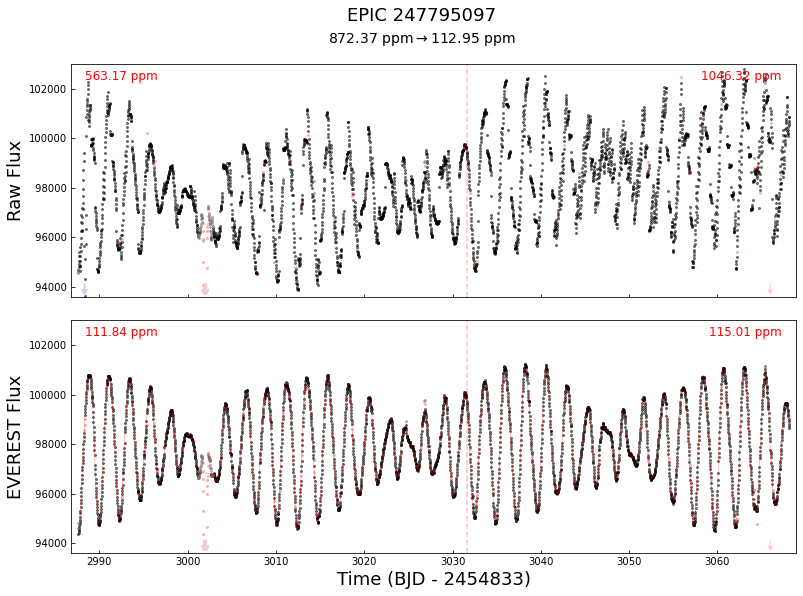

In [2]:
# retrieve light curve
v928tau = everest.Everest(247795097)

# plot light curve
v928tau.plot()

In [3]:
# extract data
time  = v928tau.time              # time
flux  = v928tau.fcor              # corrected flux
error = v928tau.cdpp / 1e6        # Combined Differential Photometric Precision in ppm
error *= np.ones_like(flux)       # making an error array

# remove nan's
mask = ~np.isnan(flux)
time  = time[mask]
flux  = flux[mask]
error = error[mask]

# normalise flux
flux  = flux / np.median(flux) 

In [4]:
# save
data_everest = np.vstack((time, flux, error)).T
np.savetxt('data/photometry/everest_lightcurve.txt', data_everest, 
           header='BJD-2454833, Flux, Error')

## Preparing the Light Curve

To prepare the light curve for the modeling of the stellar variation, we must mask out the eclipse and any significant outliers. We identify the eclipse as taking place between time 3001 and 3003 so plot between these limits to identify the eclipse.

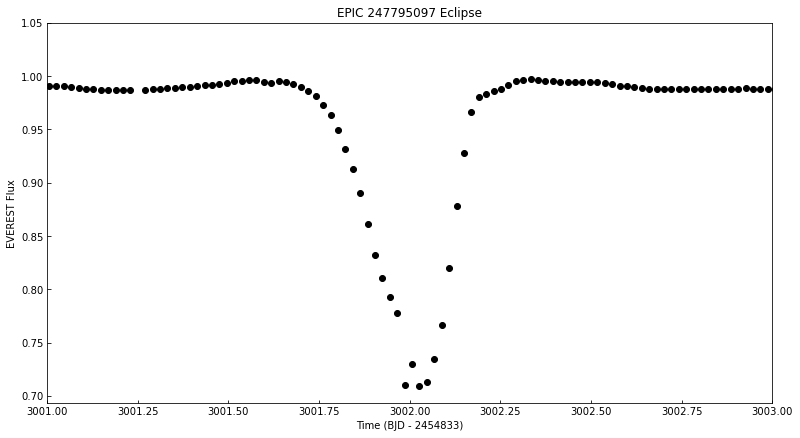

In [5]:
# plot the eclipse
plt.figure(figsize=(13,7))
plt.xlim(3001,3003)
plt.xlabel('Time (BJD - 2454833)')
plt.ylabel('EVEREST Flux')
plt.title('EPIC 247795097 Eclipse')
plt.errorbar(time, flux, yerr=error, fmt='o', color='k')
plt.show()

Removing bad data, particularly: the eclipse, the last bit of data, and flux outliers < 95%

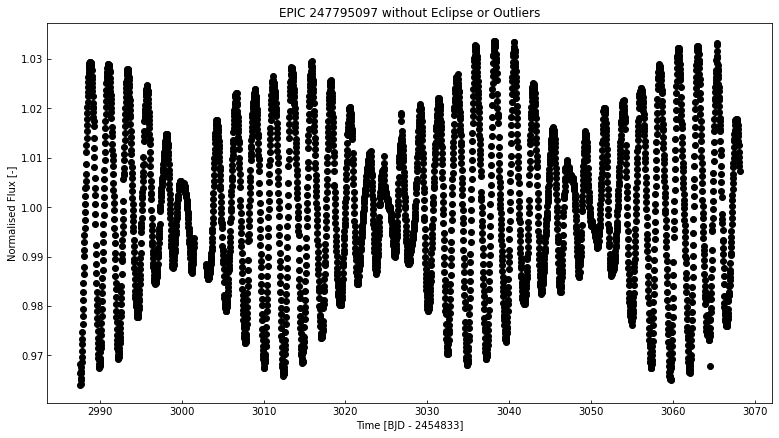

In [6]:
# mask out eclipse
eclipse_mask = (time > 3001.5) * (time < 3003)
stellar_mask = ~eclipse_mask
#stellar_mask2 = (time < 3015)

# mask out flux outliers
flux_mask = flux > 0.95

# full mask
mask = (flux_mask * stellar_mask) # * stellar_mask2)

# sv = stellar variation
time_sv  = time[mask]
flux_sv  = flux[mask]
error_sv = error[mask]

# plot to check
plt.figure(figsize=(13,7))
plt.xlabel('Time [BJD - 2454833]')
plt.ylabel('Normalised Flux [-]')
plt.title('EPIC 247795097 without Eclipse or Outliers')
plt.errorbar(time_sv, flux_sv, yerr=error_sv, fmt='o', color='k')
plt.show()

## Creating the Model

We start off by fitting a linear trend and then performing a Lomb-Scargle analysis to determine the periods of the modulation. We then write an MCMC code with the best fit parameters from the linear and Lomb-Scargle fit to get the "best fit" for the model.

### Linear Component

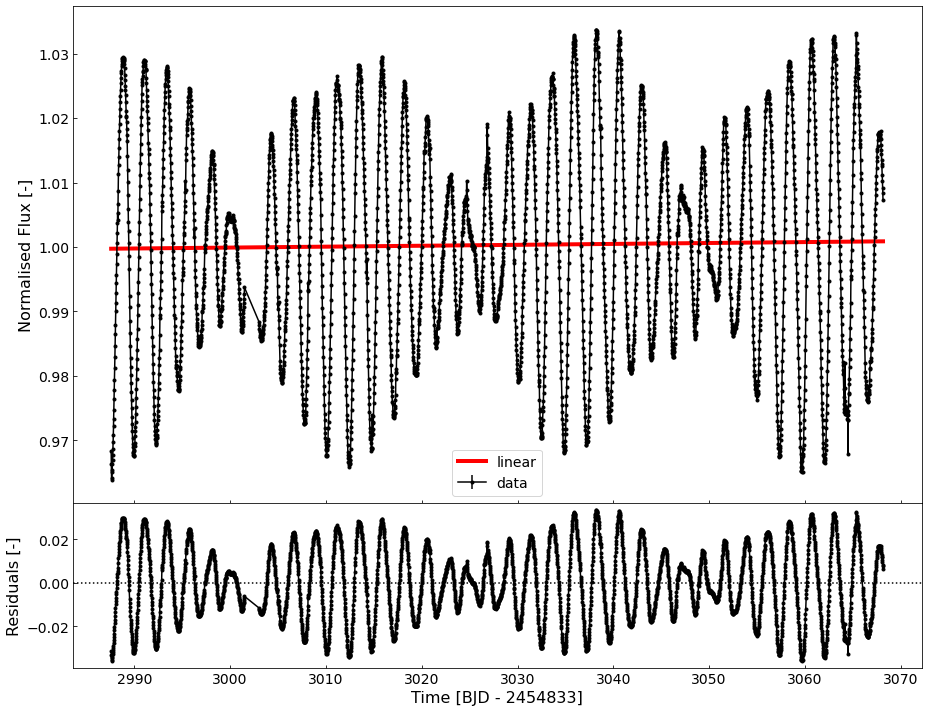

the best fit parameters are m = 0.000014218489, b = 0.999731740516


In [12]:
linear_trend = lambda P, time: sv.line(time, *P, time[0])
line_curvefit = lambda time, m, c: sv.line(time, m, c, time[0])
p_line, _ = curve_fit(line_curvefit, time_sv, flux_sv, sigma=error_sv)
line_flux = sv.line(time_sv, *p_line, time_sv[0])

# sanity check with a plot
_, = mcmc.plot_models(time_sv, flux_sv, error_sv, [linear_trend], [p_line], ['linear'])


print('the best fit parameters are m = %.12f, b = %.12f' % (p_line[0], p_line[1]))

### Lomb-Scargle Periodogram

We perform Lomb-Scargle Periodograms to determine the sinusoidal components of the light curve. First we must remove the linear component.

In [13]:
# new flux (removed linear trend) for lomb_scargle
ls1_flux = flux_sv - line_flux

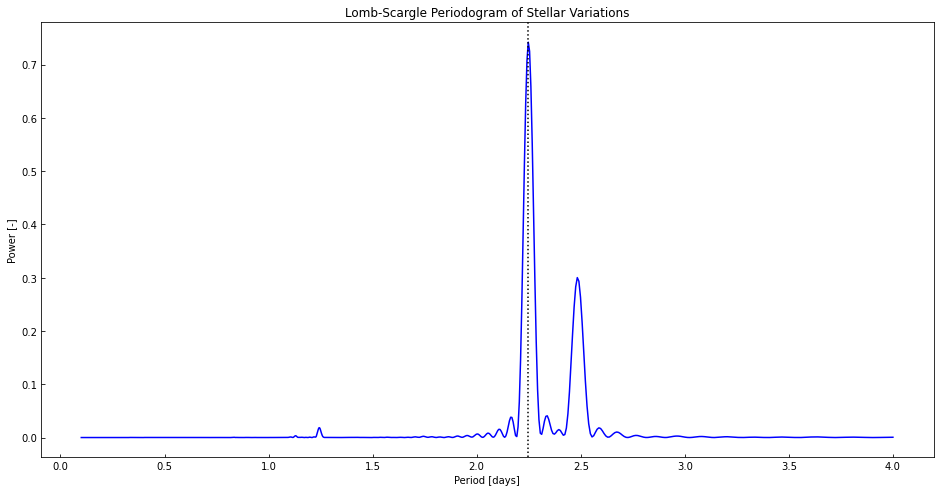

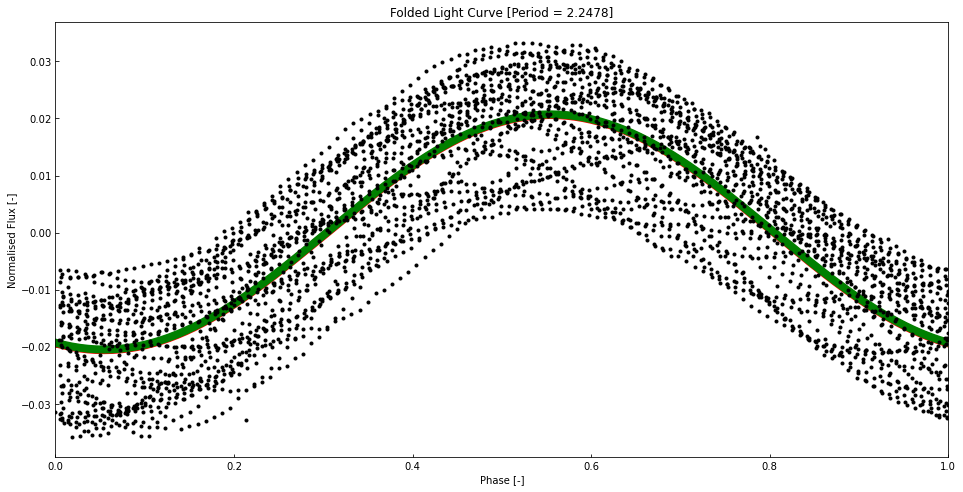

-0.020605 sin(2 pi time / 2.2478 + 1.2280)


In [14]:
ls_p1b, ls2_flux = sv.lombscargle_periodogram(time_sv, ls1_flux, error_sv)

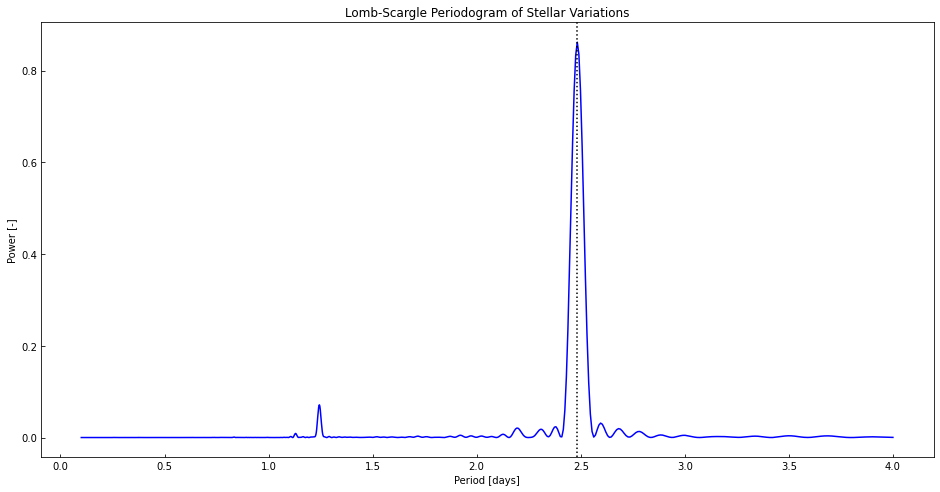

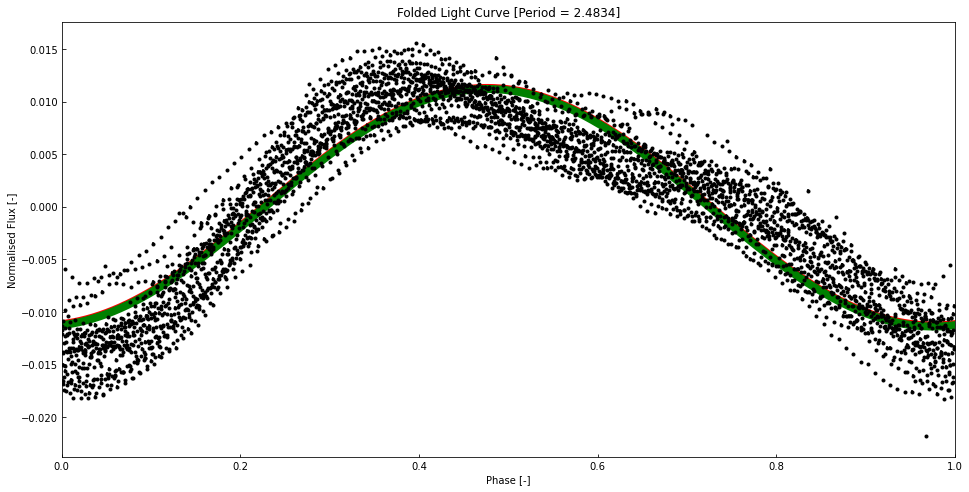

-0.011300 sin(2 pi time / 2.4834 + 1.7199)


In [15]:
ls_p2b, ls3_flux = sv.lombscargle_periodogram(time_sv, ls2_flux, error_sv)

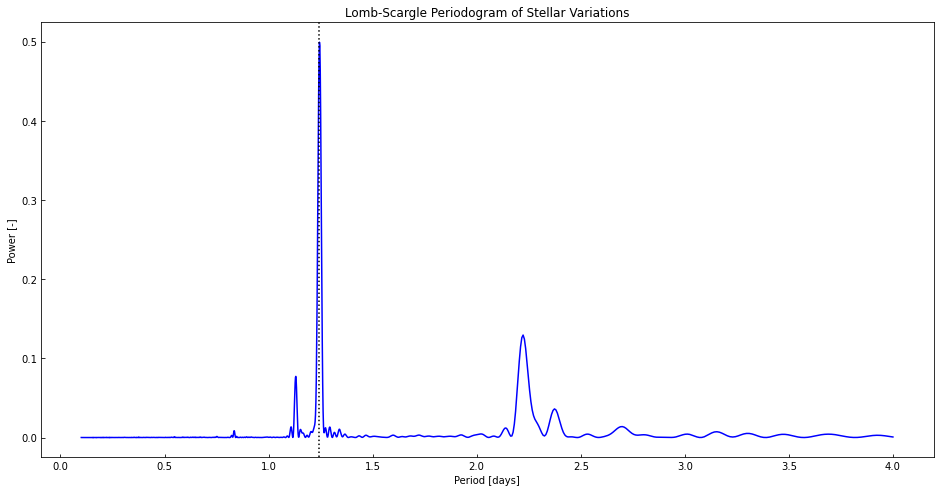

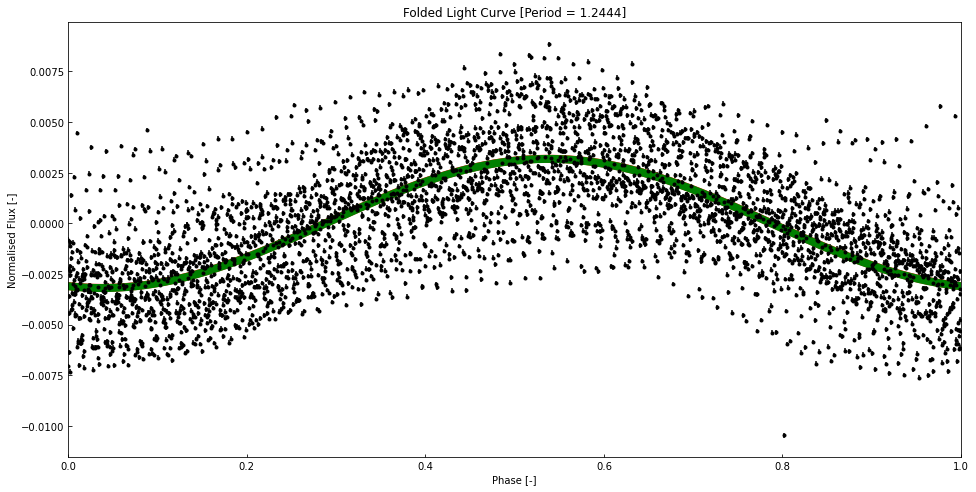

-0.003189 sin(2 pi time / 1.2444 + 1.3327)


In [16]:
ls_p3b, ls4_flux = sv.lombscargle_periodogram(time_sv, ls3_flux, error_sv)

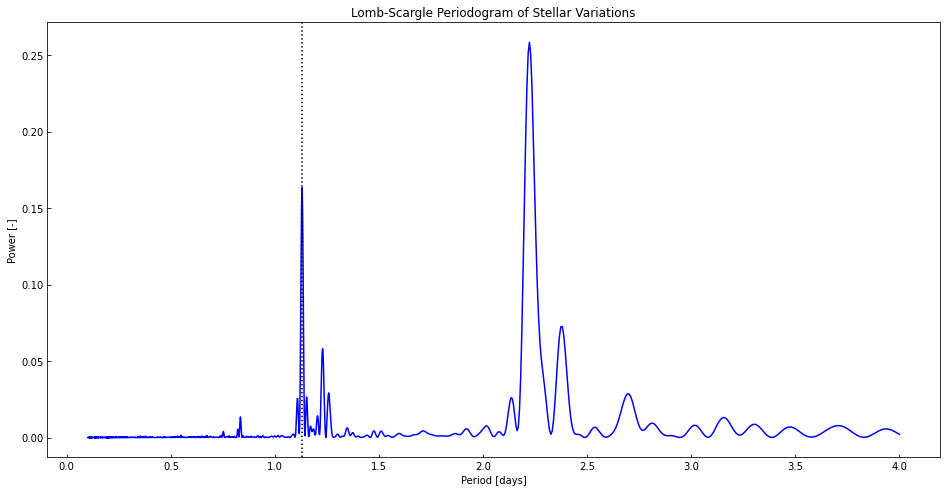

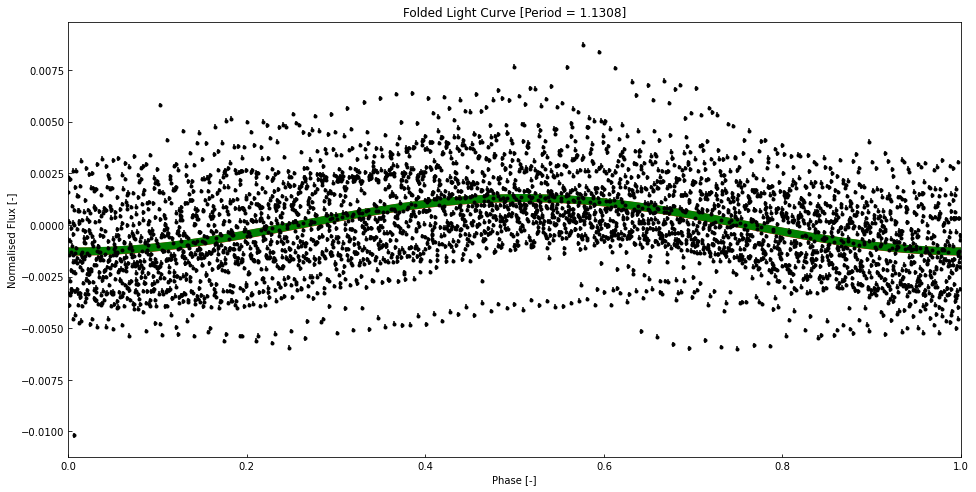

-0.001294 sin(2 pi time / 1.1308 + 1.5179)


In [17]:
ls_p4b, ls5_flux = sv.lombscargle_periodogram(time_sv, ls4_flux, error_sv, peak_ind=1)

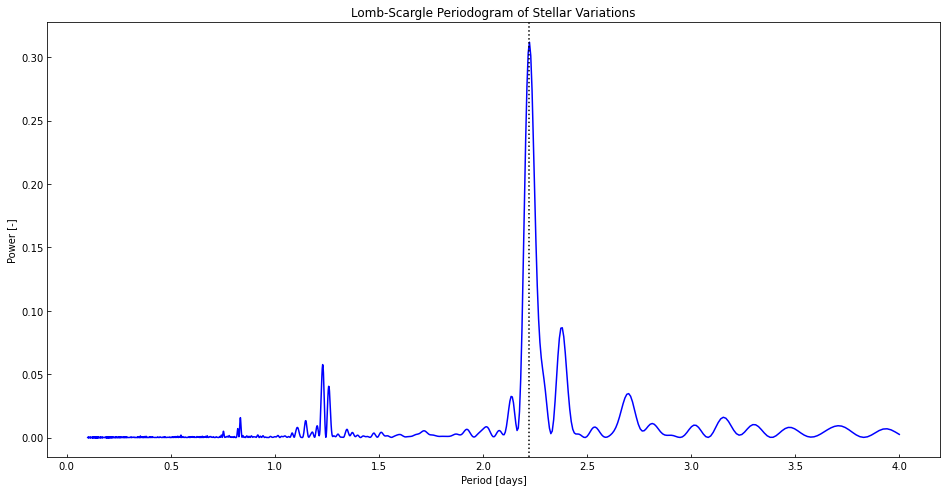

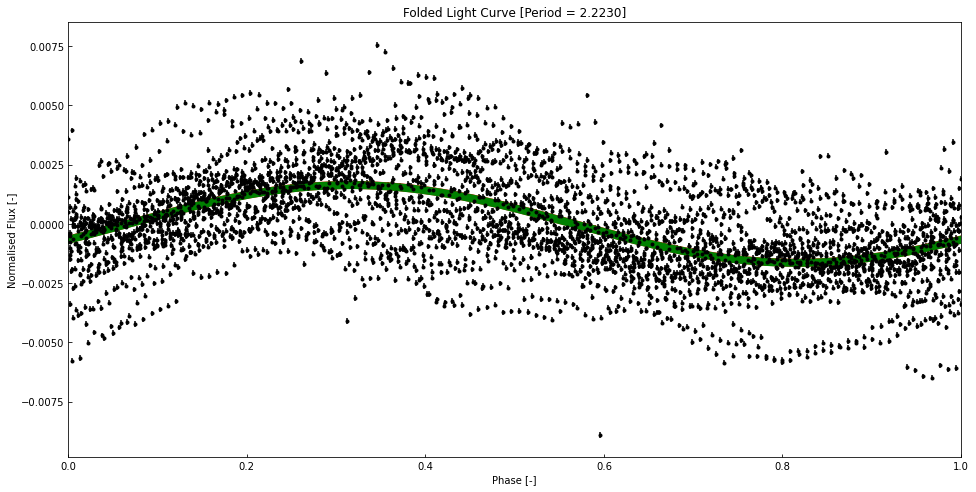

-0.001640 sin(2 pi time / 2.2230 + 2.7245)


In [18]:
ls_p5b, ls6_flux = sv.lombscargle_periodogram(time_sv, ls5_flux, error_sv)

We use the first four periods identified.

In [19]:
periods = []
for pb in [ls_p1b, ls_p2b, ls_p3b, ls_p4b]:
    print('the period is %.4f days' % pb[1])
    periods.append(pb[1])
periods = np.sort(periods)

the period is 2.2478 days
the period is 2.4834 days
the period is 1.2444 days
the period is 1.1308 days


Below we determine whether or not these are harmonics of each other.

In [20]:
# for each period determine what the minimum
def test_harmonic(fund_period, test_periods): 
    try:
        ratios = test_periods / fund_period 
        harmonics = np.round(ratios).astype(np.int) 
        discrepancies = 100 * np.abs(harmonics - ratios) 
        for test_period, harmonic, discrepancy in zip(test_periods, harmonics, discrepancies): 
            print('the discrepancy between %.4f and %.4f is %.2f %% in the %i harmonic' % (fund_period, test_period, discrepancy, harmonic)) 
    except:
        pass
    return None

for num, fundamental_period in enumerate(periods):
    test_harmonic(fundamental_period, periods[num+1:])
    print('')

the discrepancy between 1.1308 and 1.2444 is 10.04 % in the 1 harmonic
the discrepancy between 1.1308 and 2.2478 is 1.23 % in the 2 harmonic
the discrepancy between 1.1308 and 2.4834 is 19.60 % in the 2 harmonic

the discrepancy between 1.2444 and 2.2478 is 19.37 % in the 2 harmonic
the discrepancy between 1.2444 and 2.4834 is 0.43 % in the 2 harmonic

the discrepancy between 2.2478 and 2.4834 is 10.48 % in the 1 harmonic




We define the stellar variation model

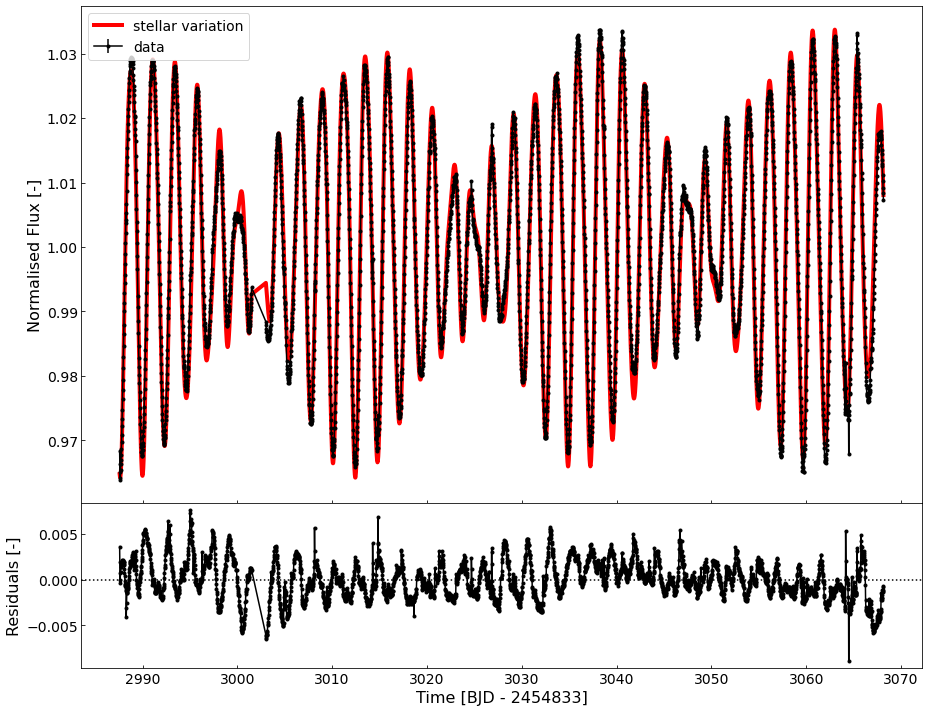

In [21]:
# determine best fit parameters from lomb scargle
pb_sines = np.array([ls_p1b, ls_p2b, ls_p3b, ls_p4b]).T.flatten()
Pb_ls = np.concatenate((p_line, pb_sines), 0)

# define the model
stellar_variation = lambda P, time: sv.line(time, *P[0:2], time[0]) + sv.sines(time, P[2:6], P[6:10], P[10:14], time[0])


_, = mcmc.plot_models(time_sv, flux_sv, error_sv, [stellar_variation], [Pb_ls], ['stellar variation'])


From this analysis it is clear that $P_1$ and $P_2$ are the two fundamental periods of the stellar variations, each with a single harmonic, namely $P_4$ and $P_3$ respectively. Any further cleaning is non-periodic and as such is beyond the scope of this cleaning (also it cleans noise on the order of ~0.5%).

## MCMC Fit

Now we run an MCMC routine to ensure that we get the best possible fit with multi-sampling of the parameter space, and then we can run a complex model with all free parameters. Below we define all the necessary MCMC routines

In [22]:
# defining boundaries
ml, mu = (-0.1, 0.1)    # slope
cl, cu = (0.9, 1.1)     # y-intercept
al, au = (-0.05, 0.05)  # amplitudes of sines
tl, tu = (0., 4.)       # periods of sines
pl, pu = (0., 2*np.pi)  # phases of sines

def stellar_variation_prior(P):
    '''
    gives the limit of the parameter space for the model. note that the model
    is always composed of a linear trend and x number of sinusoids

    Parameters
    ----------
    P : list, tuple, array of floats
        contains parameters of the model
            m --> slope of the line
            b --> intercept of the line
            ax --> amplitudes of the sinusoids
            tx --> periods of the sinusoids
            px --> phases of the sinusoids

    Returns
    -------
    prior : float
        0 if in parameter space, - infinity if outside
    '''
    # number of sines (-2 = line; 3 parameters per sine)
    ns = int((len(P) - 2) / 3)
    # define bounds
    bounds = [(ml, mu), (cl, cu)] + ns*[(al, au)] + ns*[(tl, tu)] + ns*[(pl, pu)]
    prior = 0.0
    for param, bound in zip(P, bounds):
        if bound[0] <= param <= bound[1]:
            prior = 0.0
        else:
            prior = -np.inf
            break
    return prior

### Gaussian Ball

This MCMC routine will look centred on the solution found by the Lomb-Scargle sections above

In [23]:
# parameter names and units
lbls = ['slope', 'y-intercept', 'amplitude 1', 'amplitude 2', 
        'amplitude 3', 'amplitude 4', 'period 1', 'period 2', 
        'period 3', 'period 4', 'phase 1', 'phase 2', 'phase 3',
        'phase 4']
units = ['L*/day', 'L*', 'L*', 'L*', 'L*', 'L*', 'day', 'day', 
         'day', 'day', 'rad', 'rad', 'rad', 'rad']

# boundaries
ns = 4
bounds = [(ml, mu), (cl, cu)] + ns*[(al, au)] + ns*[(tl, tu)] + ns*[(pl, pu)]

Run the MCMC itself

#### Small Ball (1e-8)

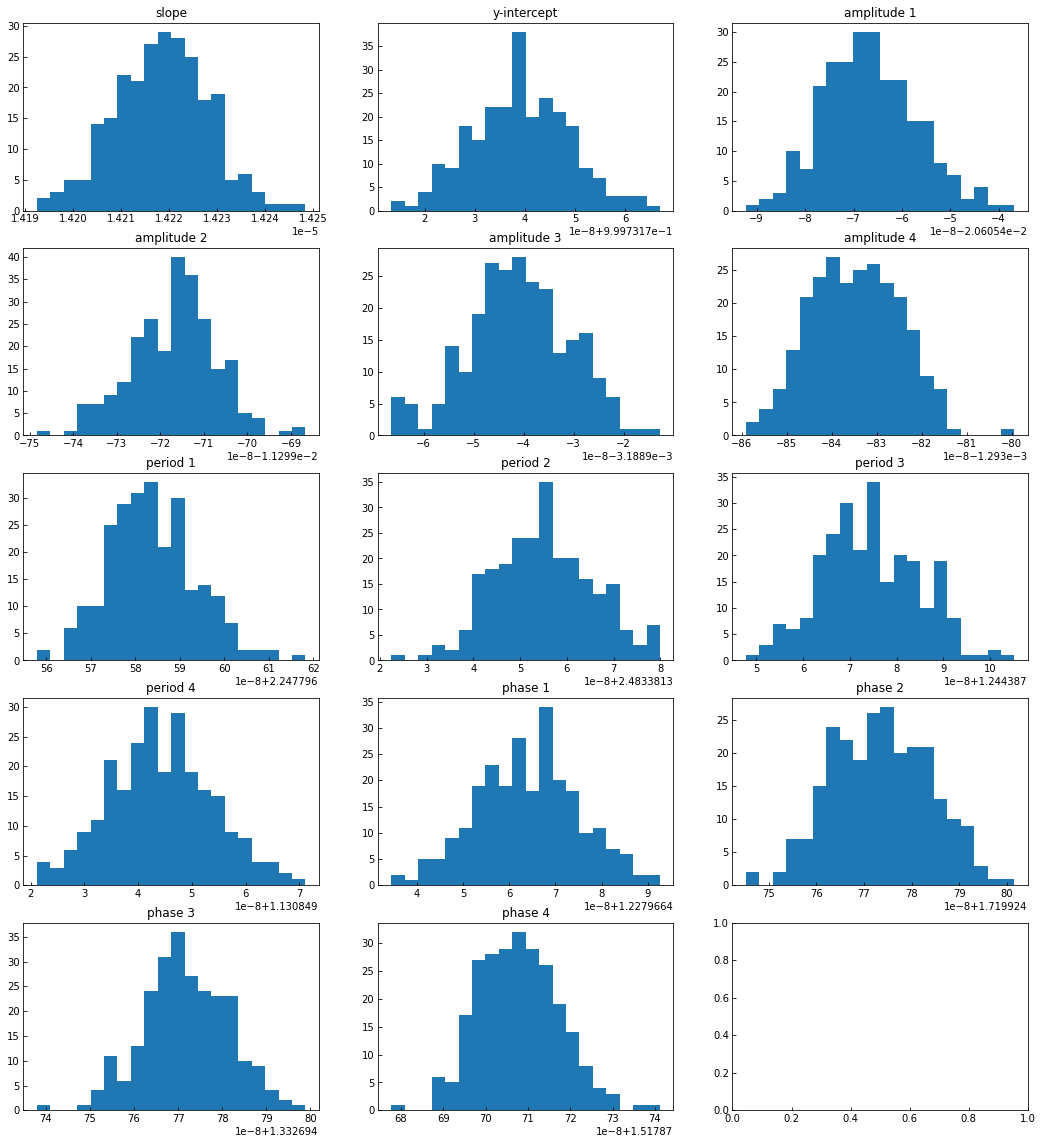

In [25]:
# get gaussian p0
p0_small = mcmc.ball_p0(Pb_ls, 250, 1e-8, bounds)
# plot histogram
mcmc.plot_hist(p0_small, lbls=lbls, ncols=3)

In [27]:
# setting savename
be_small = 'models/mcmc_backends/sv_gb_1e-8.h5'

# run MCMC
args = (time_sv, flux_sv, error_sv, stellar_variation, stellar_variation_prior)
pb_small, sampler_small = mcmc.run_mcmc(*args, p0_small, 10000, savename=be_small, reset=True)

# load MCMC
BE_small = emcee.backends.HDFBackend(be_small)
sampler_small = emcee.EnsembleSampler(250, 14, mcmc.lnprob, args=args, backend=BE_small)

100%|██████████| 10000/10000 [12:37<00:00, 13.20it/s]


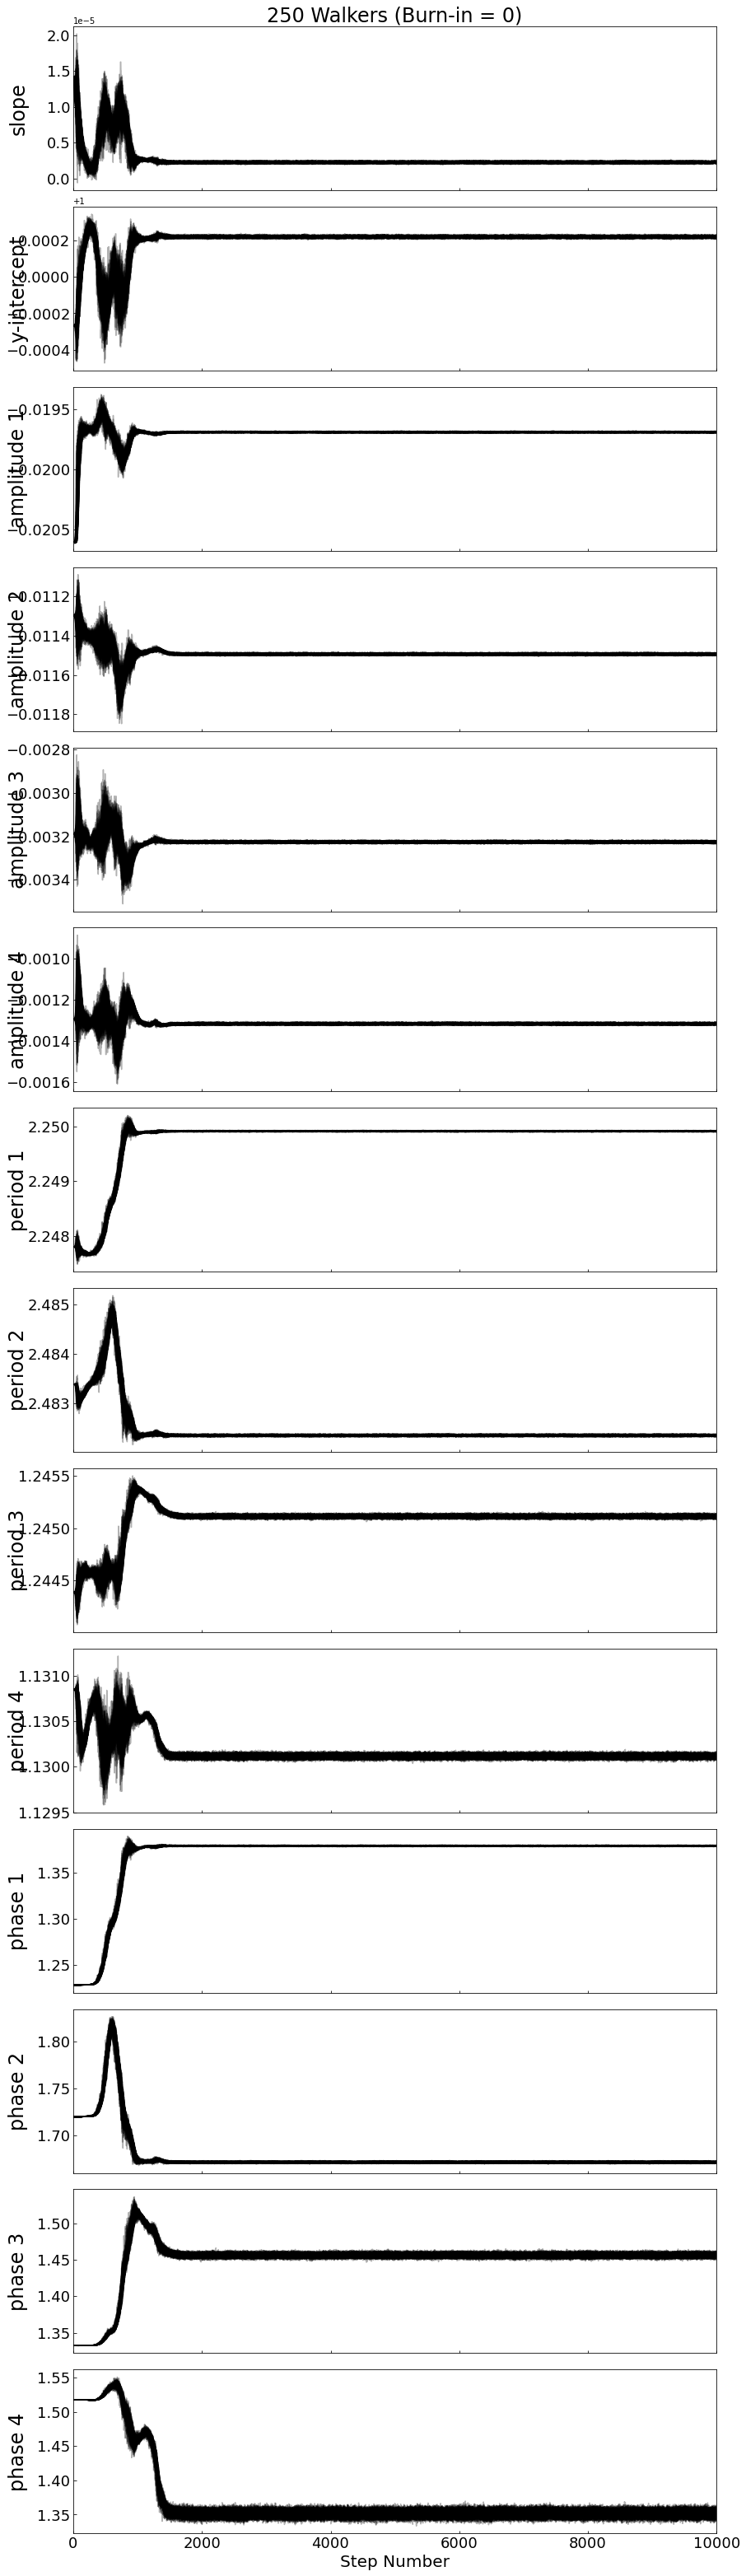

In [28]:
mcmc.plot_walkers(sampler_small, lbls=lbls)

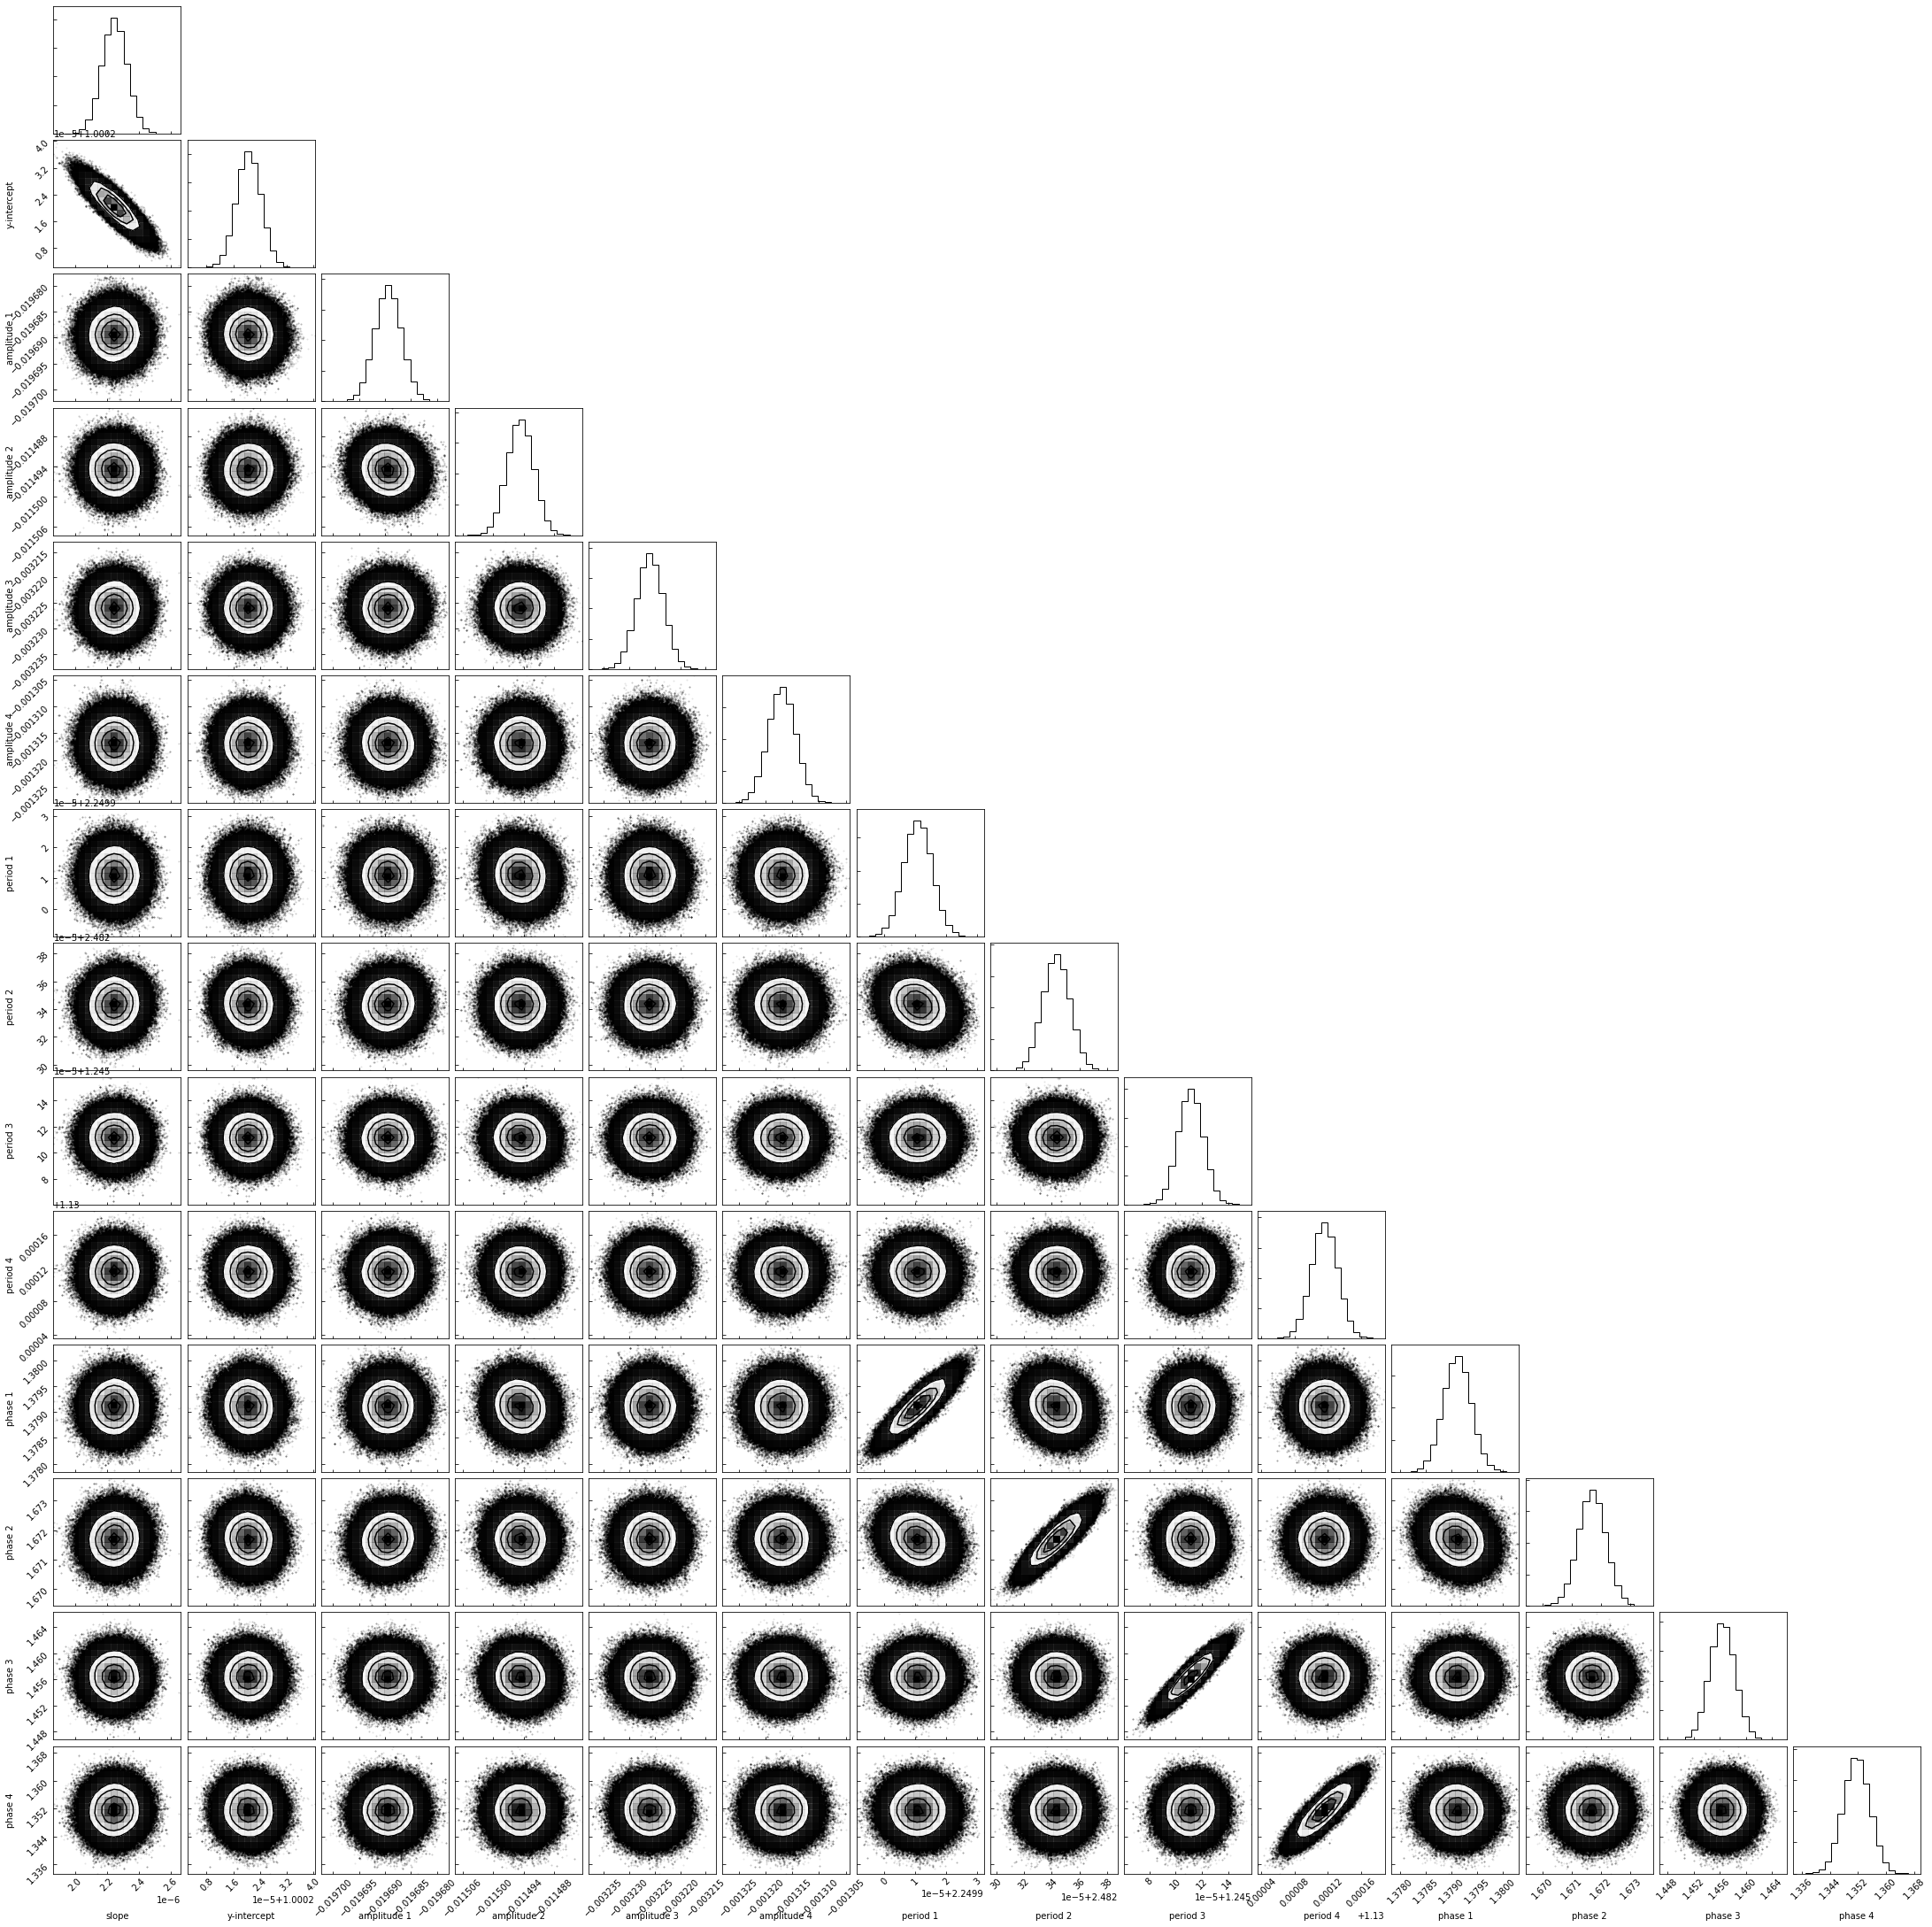

In [29]:
mcmc.plot_triangle(sampler_small, cut=2000, lbls=lbls)

In [30]:
stats_small, Pb_small = mcmc.stats(sampler_small, cut=2000)

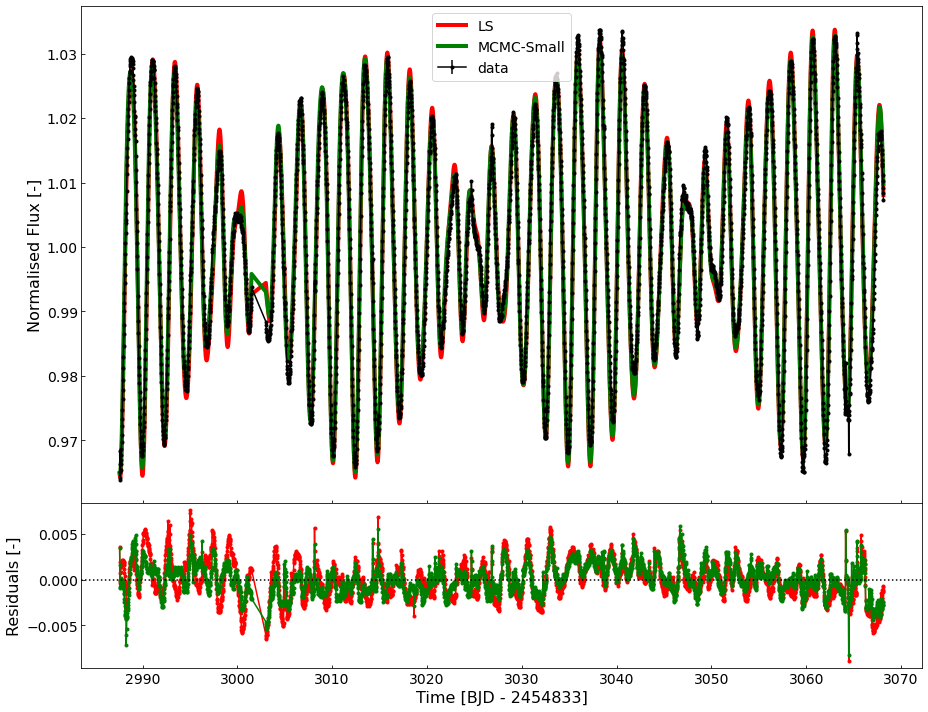

In [31]:
chi2_sls = mcmc.plot_models(time_sv, flux_sv, error_sv, 2*[stellar_variation], [Pb_ls, Pb_small], 
                 ['LS','MCMC-Small'])

In [32]:
print('chi2 mcmc small   = %.16f' % chi2_sls[1])
print('chi2 lomb scargle = %.16f' % chi2_sls[0])

chi2 mcmc small   = 792316.0644920062040910
chi2 lomb scargle = 1284944.7258167117834091


#### Large Ball (1e-2)

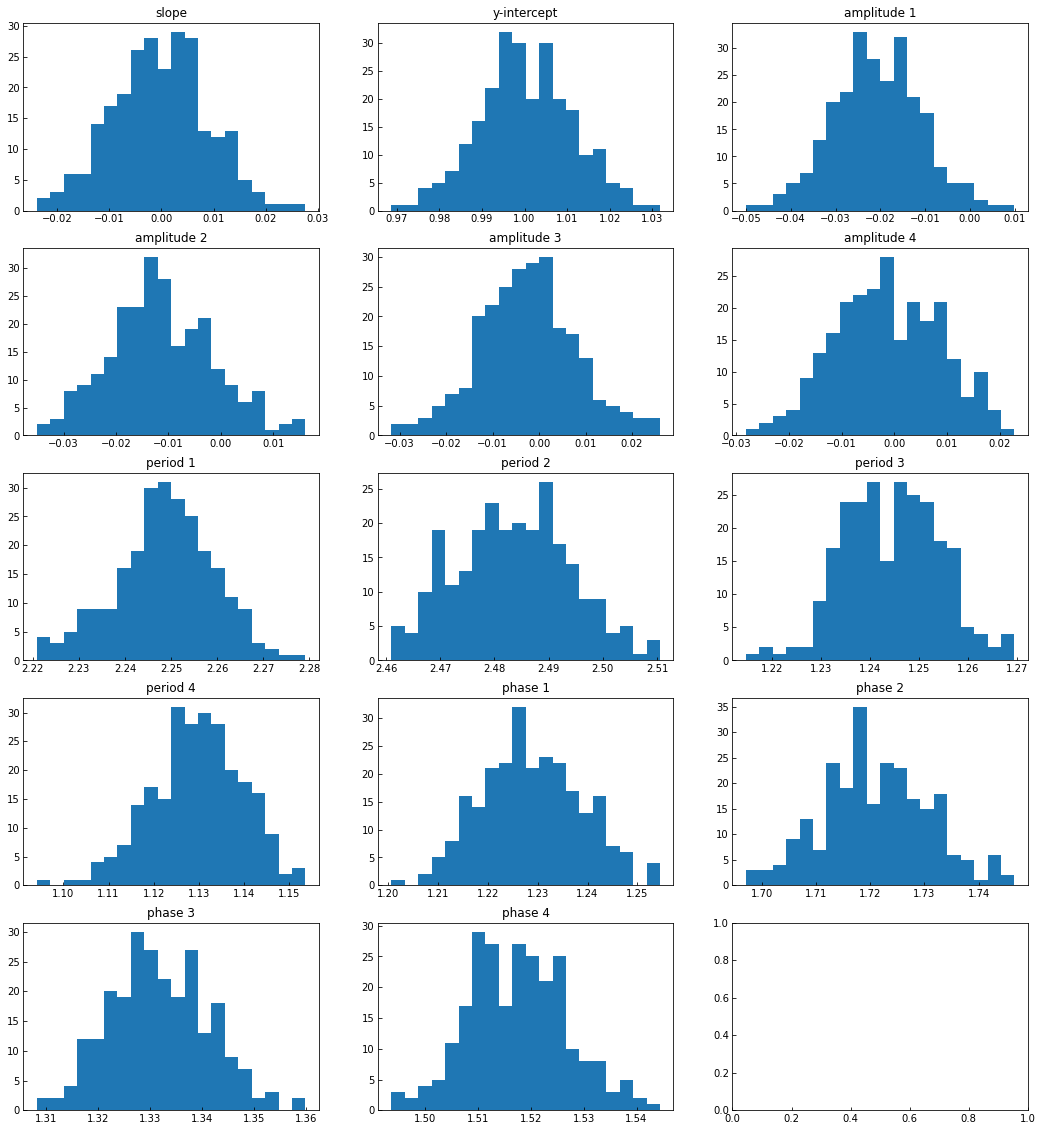

In [33]:
# get gaussian p0
p0_large = mcmc.ball_p0(Pb_ls, 250, 1e-2, bounds)
# plot histogram
mcmc.plot_hist(p0_large, lbls=lbls, ncols=3)

In [34]:
# setting savename
be_large = 'models/mcmc_backends/sv_gb_1e-2.h5'

# run MCMC
pb_large, sampler_large = mcmc.run_mcmc(*args, p0_large, 10000, savename=be_large, reset=True)

# load MCMC
BE_large = emcee.backends.HDFBackend(be_large)
sampler_large = emcee.EnsembleSampler(250, 14, mcmc.lnprob, args=args, backend=BE_large)

100%|██████████| 10000/10000 [12:09<00:00, 13.70it/s]


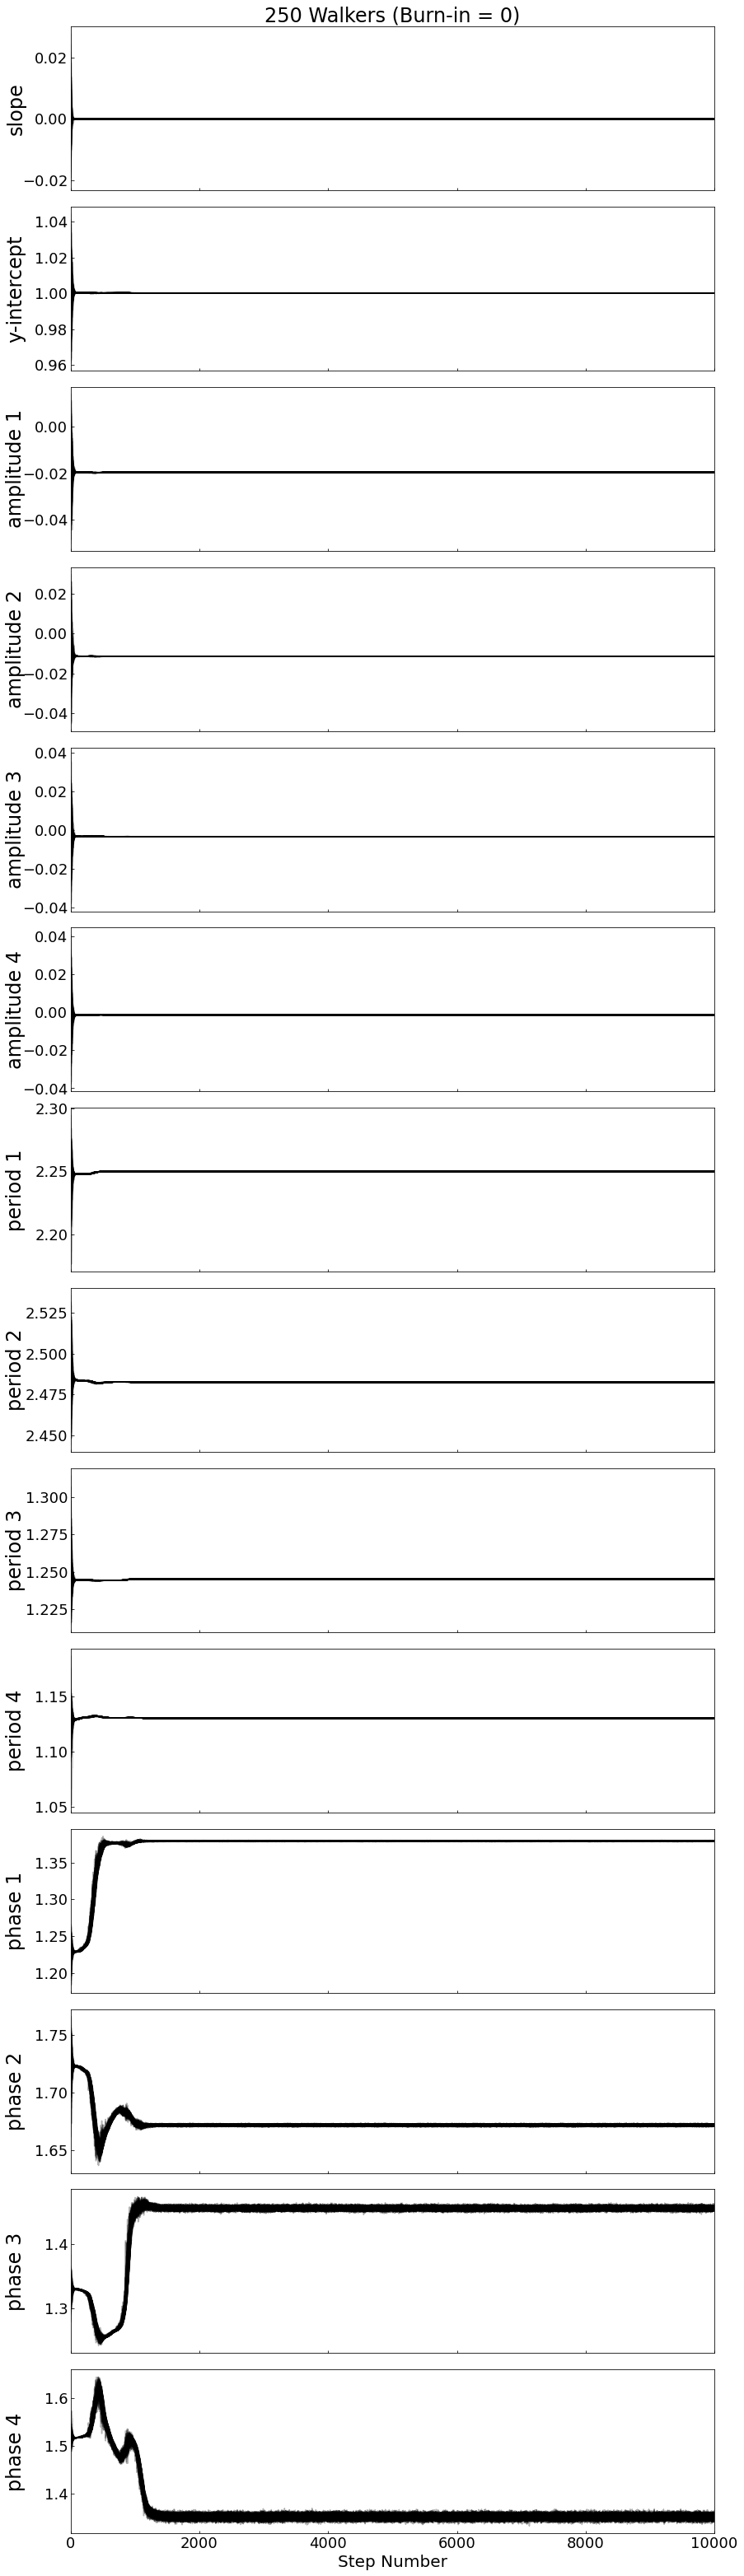

In [35]:
mcmc.plot_walkers(sampler_large, lbls=lbls)

In [ ]:
mcmc.plot_triangle(sampler_large, cut=2000, lbls=lbls)

In [ ]:
stats_large, Pb_large = mcmc.stats(sampler_large, cut=2000)


In [ ]:
chi2_lls = mcmc.plot_models(time_sv, flux_sv, error_sv, 2*[stellar_variation], [Pb_ls, Pb_large],
                 ['LS','MCMC-Large'])

In [ ]:
print('chi2 mcmc large   = %.16f' % chi2_lls[1])
print('chi2 lomb scargle = %.16f' % chi2_lls[0])

## Compare All

Here we compare the Lomb-Scargle Fit to the Large and the Small Gaussian Ball MCMC Fits.

In [ ]:
chi2 = mcmc.plot_models(time_sv, flux_sv, error_sv, 3*[stellar_variation], 
                 [Pb_ls, Pb_large, Pb_small], ['LS', 'MCMC-Large', 'MCMC-Small'])

In [ ]:
print('for the Lomb-Scargle we find')
print('----------------------------')
mcmc.print_parameters(Pb_ls, lbls, units, 8)
print('chi2 lomb scargle = %.16f' % chi2[0])

In [ ]:
print('for the MCMC large we find')
print('--------------------------')
mcmc.print_parameters(Pb_large, lbls, units, 8)
print('chi2 mcmc large   = %.16f' % chi2[1])

In [ ]:
print('for the MCMC small we find')
print('--------------------------')
mcmc.print_parameters(Pb_small, lbls, units, 8)
print('chi2 mcmc small   = %.16f' % chi2[2])

We determine that the MCMC large gaussian ball contains the best fit parameters

## Determining Harmonics

Here we determine whether or not the periods for the sinusoids are harmonics of each other

In [ ]:
periods_mcmc = sorted(Pb_large[6:10])
for num, fundamental_period in enumerate(periods_mcmc):
    test_harmonic(fundamental_period, periods_mcmc[num+1:])
    print('')

We find that period 1 and 3 are harmonics (2nd) and period 2 and 4 are also harmonics (2nd).

## Saving Best Fit Parameters and Light Curve

In [ ]:
# save best-fit parameters and light curve
np.save('models/best_fits/stellar_variation.npy', Pb_large)

In [ ]:
# create the data file containing the light curve
delta_flux = flux - sv.stellar_variation_model(Pb_large, time)
blended_flux = delta_flux + 1
deblended_flux = 2 * delta_flux + 1

# saving the data file
data = np.vstack((time, blended_flux, deblended_flux, error)).T
np.savetxt('data/photometry/eclipse_lightcurve.txt', data, 
           header='BJD-2454833, Blended_Flux, Deblended_Flux, Error')